In [2]:
%load_ext autoreload
%autoreload 2

In [36]:
from argparse import Namespace
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from turboflow.datasets.turb2D import Turb2D

In [4]:
data_path = Path('/','home','dicarlo_d','Documents','Datasets','Turb2D.hdf5')
turb2D = Turb2D(data_path)

In [5]:
t = 666
turb2D.load_data(t, only_vel_field=False)

In [16]:
dt = turb2D.delta_t

(256, 256, 2)
(256, 256, 2)


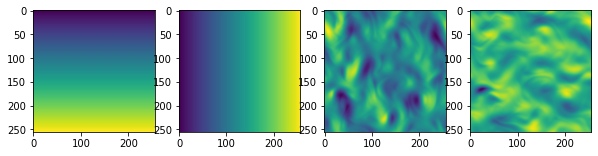

In [17]:
X = turb2D.xy
u = turb2D.uv

print(X.shape)
print(u.shape)

plt.figure(figsize=(10,10))
plt.subplot(141)
plt.imshow(X[:,:,0])
plt.subplot(142)
plt.imshow(X[:,:,1])
plt.subplot(143)
plt.imshow(u[:,:,0])
plt.subplot(144)
plt.imshow(u[:,:,1])
plt.show()

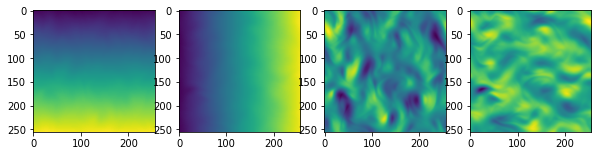

In [18]:
# 1. compute the flow map (with runge-kutta)
def flowmap(u, Xstart, step):
    dt = step
    return Xstart + dt*u

vel = turb2D.uv
X1 = flowmap(vel, X, dt)

plt.figure(figsize=(10,10))
plt.subplot(141)
plt.imshow(X1[:,:,0])
plt.subplot(142)
plt.imshow(X1[:,:,1])
plt.subplot(143)
plt.imshow(u[:,:,0])
plt.subplot(144)
plt.imshow(u[:,:,1])
plt.show()

In [41]:
t = np.arange(0,300,4)
turb2D.load_data(t, only_vel_field=False)
u = turb2D.uv
x = turb2D.xy
t = turb2D.t

print(u.shape)
print(x.shape)
print(t.shape)

(75, 256, 256, 2)
(75, 256, 256, 2)
(75,)


In [42]:
def flowmap(u, Xstart, step):
    dt = step
    return Xstart + dt*u


def computeFTLE(uv, xy):
    
    H = uv.shape[1]
    T = uv.shape[0]
    FTLE = np.zeros([T,H,H])
    dt = 0.01
    
    for t in tqdm(range(T)):
        
        X = xy[t,...]
        X1 = flowmap(uv[t,...], X, dt)
        
        for i in range(1,H-1):
            for j in range(1,H-1):

                J = np.zeros([2,2])
                J[0,0] = (X1[i+1,j,0]-X1[i-1,j,0])/(X[i+1,j,0]-X[i-1,j,0])
                J[0,1] = (X1[i,j+1,0]-X1[i,j-1,0])/(X[i,j+1,1]-X[i,j-1,1])
                J[1,0] = (X1[i+1,j,1]-X1[i-1,j,1])/(X[i+1,j,0]-X[i-1,j,0])
                J[1,1] = (X1[i,j+1,1]-X1[i,j-1,1])/(X[i,j+1,1]-X[i,j-1,1])

                D = np.dot(J.T,J)
                # its largest eigenvalue
                lam = np.linalg.eigvals(D)
                FTLE[t,i,j] = np.log(np.max(lam))/(2*dt)
                
#         plt.figure(figsize=(10,10))
#         plt.imshow(FTLE[t,...])
#         plt.colorbar()
#         plt.show()
            
    return FTLE
            
FTLE = computeFTLE(u, x)

 16%|████████████████▍                                                                                      | 12/75 [00:43<03:49,  3.64s/it]


KeyboardInterrupt: 